# Final Project- ECG Signals

## Importing:

In [39]:
pip install wfdb

In [70]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     --------------------- ------------------ 30.

In [189]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
                           accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer


## EDA

In [41]:
path= 'C:/Users/Tal-Shachar\Google Drive/Naya-DS/Final project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
data = pd.read_csv(path+'ptbxl_database.csv', index_col=0)
data.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21799 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  infarc

In [43]:
len(set(data.report))

9887

### Load signals data:

In [44]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# path = 'path/to/ptbxl/'
# path= 'C:/Users/Tal-Shachar\Google Drive/Naya-DS/Final project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [45]:
X_test.shape

(2198, 1000, 12)

In [186]:
X_train.shape

(19601, 1000, 12)

In [46]:
y_test.shape

(2198,)

### Looking at the various categories in y:

In [195]:
categories_list = y_train.astype(str).unique()
categories_list

array(["['NORM']", "['MI']", '[]', "['STTC']", "['HYP']", "['CD']",
       "['STTC', 'MI']", "['HYP', 'CD']", "['CD', 'MI']",
       "['STTC', 'CD']", "['HYP', 'MI']", "['STTC', 'HYP', 'MI']",
       "['STTC', 'HYP']", "['CD', 'STTC', 'MI']", "['NORM', 'CD']",
       "['CD', 'STTC', 'HYP', 'MI']", "['STTC', 'HYP', 'CD']",
       "['MI', 'CD']", "['NORM', 'STTC']", "['CD', 'HYP', 'MI']",
       "['NORM', 'STTC', 'CD']", "['NORM', 'HYP']", "['MI', 'HYP', 'CD']",
       "['MI', 'STTC', 'CD']", "['MI', 'STTC', 'HYP', 'CD']",
       "['MI', 'NORM', 'HYP', 'CD']"], dtype=object)

In [200]:
y_train.value_counts()

diagnostic_superclass
[NORM]                 8157
[MI]                   2276
[STTC]                 2158
[CD]                   1524
[CD, MI]               1149
[STTC, HYP]             708
[STTC, MI]              538
[HYP]                   479
[STTC, CD]              433
[]                      371
[NORM, CD]              362
[STTC, HYP, MI]         320
[HYP, CD]               273
[CD, STTC, MI]          200
[STTC, HYP, CD]         186
[HYP, MI]               166
[CD, STTC, HYP, MI]     138
[CD, HYP, MI]           106
[NORM, STTC]             24
[MI, CD]                 15
[MI, HYP, CD]             6
[NORM, STTC, CD]          5
[NORM, HYP]               2
[MI, STTC, CD]            2
[MI, STTC, HYP, CD]       2
[MI, NORM, HYP, CD]       1
Name: count, dtype: int64

In [196]:
len(categories_list)

26

In [86]:
y_test.astype(str).unique()

array(["['NORM']", "['MI']", "['CD']", "['STTC']",
       "['CD', 'STTC', 'HYP', 'MI']", "['NORM', 'CD']",
       "['STTC', 'HYP', 'MI']", "['STTC', 'HYP']",
       "['STTC', 'HYP', 'CD']", '[]', "['MI', 'CD']", "['STTC', 'CD']",
       "['STTC', 'MI']", "['CD', 'STTC', 'MI']", "['CD', 'MI']",
       "['HYP', 'MI']", "['HYP']", "['CD', 'HYP', 'MI']", "['HYP', 'CD']",
       "['NORM', 'HYP', 'CD']", "['NORM', 'STTC']",
       "['MI', 'STTC', 'CD']"], dtype=object)

In [201]:
y_test.value_counts()

diagnostic_superclass
[NORM]                 912
[MI]                   256
[STTC]                 242
[CD]                   184
[CD, MI]               129
[STTC, HYP]             73
[STTC, MI]              61
[HYP]                   56
[NORM, CD]              45
[STTC, HYP, MI]         41
[]                      40
[STTC, CD]              38
[HYP, CD]               27
[STTC, HYP, CD]         25
[CD, STTC, MI]          20
[HYP, MI]               17
[CD, STTC, HYP, MI]     16
[CD, HYP, MI]            5
[MI, CD]                 4
[NORM, STTC]             4
[NORM, HYP, CD]          2
[MI, STTC, CD]           1
Name: count, dtype: int64

In [87]:
len(y_test.astype(str).unique())

22

### Looking at one person ECG signal:

In [22]:
test= pd.DataFrame(X[0])
test

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.106,0.028,-0.078,-0.067,0.092,-0.025,0.012,-0.008,0.025,0.020,-0.025,0.026
996,0.090,0.021,-0.069,-0.055,0.079,-0.023,-0.014,-0.009,-0.023,-0.027,-0.036,-0.008
997,0.069,0.000,-0.069,-0.034,0.069,-0.035,-0.001,-0.026,0.000,0.024,-0.041,-0.058
998,0.086,0.004,-0.081,-0.044,0.083,-0.038,0.001,-0.001,-0.025,0.242,-0.046,-0.098


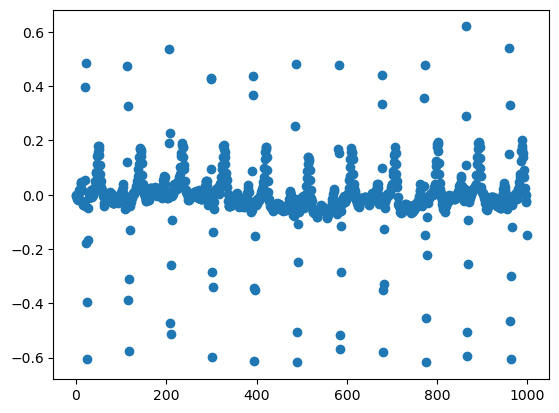

In [68]:
plt.scatter(test.index.values,test[[8]])

In [23]:
test[[0]]

,0
0,-0.119
1,-0.116
2,-0.120
3,-0.117
4,-0.103
...,...
995,0.106
996,0.090
997,0.069
998,0.086


Encoding y categories:

In [106]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.astype(str))

y_train_one_hot = to_categorical(y_train_encoded, num_classes=26)

In [202]:
print("Mapping of categories to encoded labels:")
for category, label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{category}: {label}")

Mapping of categories to encoded labels:
['CD', 'HYP', 'MI']: 0
['CD', 'MI']: 1
['CD', 'STTC', 'HYP', 'MI']: 2
['CD', 'STTC', 'MI']: 3
['CD']: 4
['HYP', 'CD']: 5
['HYP', 'MI']: 6
['HYP']: 7
['MI', 'CD']: 8
['MI', 'HYP', 'CD']: 9
['MI', 'NORM', 'HYP', 'CD']: 10
['MI', 'STTC', 'CD']: 11
['MI', 'STTC', 'HYP', 'CD']: 12
['MI']: 13
['NORM', 'CD']: 14
['NORM', 'HYP']: 15
['NORM', 'STTC', 'CD']: 16
['NORM', 'STTC']: 17
['NORM']: 18
['STTC', 'CD']: 19
['STTC', 'HYP', 'CD']: 20
['STTC', 'HYP', 'MI']: 21
['STTC', 'HYP']: 22
['STTC', 'MI']: 23
['STTC']: 24
[]: 25


## Naive model:

Majority class prediction:

In [212]:
def naive_predict(x):
    return 18

In [215]:
y_train_pred_n =[naive_predict(x) for x in range (len(X_train))]

In [207]:
accuracy_train_naive = accuracy_score(y_true= y_train_encoded, y_pred = y_train_pred_n).round(2)
accuracy_train_naive

0.42

Weightes of 2 major classes prediction:

In [225]:
y_train_pred_n2 =[13 if x%4 == 0 else 18 for x in range (len(X_train))]

In [226]:
accuracy_train_naive2 = accuracy_score(y_true= y_train_encoded, y_pred = y_train_pred_n2).round(2)
accuracy_train_naive2

0.34

Weightes of 3 major classes prediction:

In [229]:
y_train_pred_n3 =[13 if x%3 == 0 else (24 if x % 5 == 0 else 18) for x in range (len(X_train))]

In [230]:
accuracy_train_naive3 = accuracy_score(y_true= y_train_encoded, y_pred = y_train_pred_n3).round(2)
accuracy_train_naive3

0.28

## Neural network

Model: from ....

In [165]:

class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, optional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_keep_prob: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def get_model(n_classes, last_layer='sigmoid'):
    kernel_size = 16
    kernel_initializer = 'he_normal'
    # signal = Input(shape=(4096, 12), dtype=np.float32, name='signal')
    signal = Input(shape=(1024, 12), dtype=np.float32, name='signal')   
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,
    #                     kernel_initializer=kernel_initializer)([x, x])
    # x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
    #                     kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(64, 256, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer)(x)
    model = Model(signal, diagn)
    return model


In [166]:
ecg_model = get_model(26)

In [176]:
ecg_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 1024, 12)]           0         []                            
                                                                                                  
 conv1d_40 (Conv1D)          (None, 1024, 64)             12288     ['signal[0][0]']              
                                                                                                  
 batch_normalization_28 (Ba  (None, 1024, 64)             256       ['conv1d_40[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 1024, 64)             0         ['batch_normalization_28

Compile:

In [172]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
ecg_model.compile(loss='binary_crossentropy', optimizer= optimizer)

Padding:

In [168]:
X_train_padded = pad_sequences(X_train, maxlen=1024, padding='post', truncating='post')
print(X_train_padded.shape)

(19601, 1024, 12)


Fitting:

In [175]:
ecg_model.fit(X_train_padded,y_train_one_hot, epochs = 10, batch_size=128)

Epoch 1/10
154/154 [==============================] - 1588s 10s/step - loss: 0.0994
Epoch 2/10
154/154 [==============================] - 1100s 7s/step - loss: 0.0947
Epoch 3/10
154/154 [==============================] - 1091s 7s/step - loss: 0.0922
Epoch 4/10
154/154 [==============================] - 1144s 7s/step - loss: 0.0890
Epoch 5/10
154/154 [==============================] - 1110s 7s/step - loss: 0.0853
Epoch 6/10
154/154 [==============================] - 1123s 7s/step - loss: 0.0807
Epoch 7/10
154/154 [==============================] - 1194s 8s/step - loss: 0.0743
Epoch 8/10
154/154 [==============================] - 1116s 7s/step - loss: 0.0669
Epoch 9/10
154/154 [==============================] - 1108s 7s/step - loss: 0.0553
Epoch 10/10
154/154 [==============================] - 1127s 7s/step - loss: 0.0444


Predict:

In [177]:
batch_size = 32  
pred_train = []

for i in range(0, len(X_train_padded), batch_size):
    batch_predictions = ecg_model.predict(X_train_padded[i:i+batch_size])
    pred_train.append(batch_predictions)

pred_train = np.concatenate(pred_train, axis=0)

1/1 [==============================] - 1s 856ms/step


In [178]:
predicted_labels = np.argmax(pred_train, axis=1)
predicted_labels

array([18, 18, 18, ..., 18, 18, 18], dtype=int64)

In [179]:
df1= pd.DataFrame(y_train_encoded, columns =['actual'])
df2= pd.DataFrame(predicted_labels, columns =['predicted'])
result_df = pd.concat([df1, df2], axis=1)
result_df.sample(10)

,actual,predicted
12862,18,18
6668,18,18
17928,24,18
8643,18,18
17383,25,25
18765,24,18
2040,4,4
4520,18,18
4685,13,13
8662,18,18


In [180]:
labels=  list(np.unique(y_train_encoded))

Evaluation:

In [181]:
accuracy_train = accuracy_score(y_true= y_train_encoded, y_pred = predicted_labels).round(2)
accuracy_train




0.78

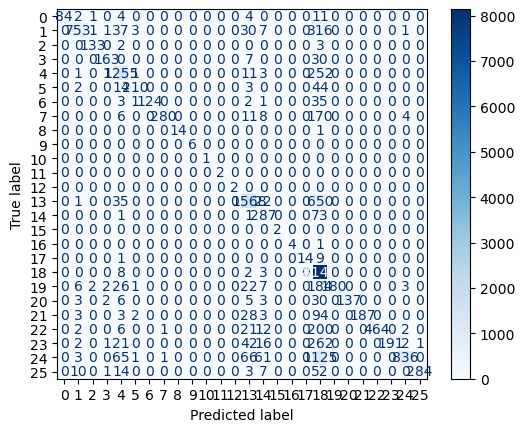

In [182]:
cm_train = confusion_matrix(y_true= y_train_encoded, y_pred = predicted_labels, labels=labels)
disp_train  = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                display_labels=labels)
disp_train.plot(cmap=plt.cm.Blues,values_format='g')


## Evaluation:

test results:

In [183]:
X_test_padded = pad_sequences(X_test, maxlen=1024, padding='post', truncating='post')

In [184]:
batch_size = 32  # Adjust this based on your available memory
pred_test = []

for i in range(0, len(X_test_padded), batch_size):
    batch_predictions = ecg_model.predict(X_test_padded[i:i+batch_size])
    pred_test.append(batch_predictions)

pred_test = np.concatenate(pred_test, axis=0)

1/1 [==============================] - 0s 473ms/step


In [185]:
y_test_encoded = label_encoder.transform(y_test.astype(str))

ValueError: y contains previously unseen labels: "['NORM', 'HYP', 'CD']"

In [ ]:
predicted_labels_test = np.argmax(pred_test, axis=1)
predicted_labels_test

In [ ]:
accuracy_test = accuracy_score(y_true= y_test_encoded, y_pred = predicted_labels_test).round(2)
accuracy_test

## Multi-label encoding

In [247]:
t= y_train[45:110]
t

ecg_id
49         [CD]
50     [CD, MI]
51       [NORM]
52         [CD]
53       [NORM]
         ...   
125      [NORM]
126      [NORM]
127      [STTC]
130      [NORM]
131        [MI]
Name: diagnostic_superclass, Length: 65, dtype: object

In [248]:

mlb = MultiLabelBinarizer()
binary_encoded = mlb.fit_transform(t)
binary_encoded

array([[1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0,

In [249]:
mlb = MultiLabelBinarizer()
y_train_m_encoded = mlb.fit_transform(y_train)
y_train_m_encoded

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [250]:
list(mlb.classes_)

['CD', 'HYP', 'MI', 'NORM', 'STTC']

In [252]:
y_test_m_encoded = mlb.transform(y_test)
y_test_m_encoded

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

### NN with multi-label encoding

In [253]:
ecg_model_ml = get_model(5)

In [254]:
ecg_model_ml.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 1024, 12)]           0         []                            
                                                                                                  
 conv1d_50 (Conv1D)          (None, 1024, 64)             12288     ['signal[0][0]']              
                                                                                                  
 batch_normalization_35 (Ba  (None, 1024, 64)             256       ['conv1d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_35 (Activation)  (None, 1024, 64)             0         ['batch_normalization_35

In [256]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
ecg_model_ml.compile(loss='binary_crossentropy', optimizer= optimizer)

In [ ]:
ecg_model_ml.fit(X_train_padded,y_train_m_encoded, epochs = 100, batch_size=128)

Epoch 1/100
154/154 [==============================] - 1203s 8s/step - loss: 0.4470
Epoch 2/100
154/154 [==============================] - 1080s 7s/step - loss: 0.4361
Epoch 3/100
154/154 [==============================] - 1129s 7s/step - loss: 0.4211
Epoch 4/100
154/154 [==============================] - 1141s 7s/step - loss: 0.4107
Epoch 5/100
154/154 [==============================] - 1089s 7s/step - loss: 0.3994
Epoch 6/100
154/154 [==============================] - 1119s 7s/step - loss: 0.3763
Epoch 7/100
154/154 [==============================] - 1149s 7s/step - loss: 0.3513
Epoch 8/100
154/154 [==============================] - 1145s 7s/step - loss: 0.3131
Epoch 9/100
154/154 [==============================] - 1134s 7s/step - loss: 0.2663
Epoch 10/100
154/154 [==============================] - 1147s 7s/step - loss: 0.2151
Epoch 11/100
154/154 [==============================] - 1140s 7s/step - loss: 0.1774
Epoch 12/100
154/154 [==============================] - 1141s 7s/step - lo

In [ ]:
batch_size = 32  
pred_train = []

for i in range(0, len(X_train_padded), batch_size):
    batch_predictions = ecg_model_ml.predict(X_train_padded[i:i+batch_size])
    pred_train.append(batch_predictions)

pred_train = np.concatenate(pred_train, axis=0)

In [ ]:
thr = 0.5


In [ ]:
encoded_pred_train =(pred_train>thr).astype(int)

In [ ]:
encoded_pred_train

In [ ]:
accuracy_train = accuracy_score(y_true= y_train_m_encoded, y_pred = encoded_pred_train).round(2)
accuracy_train